In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ast

df_2 = pd.read_csv('data/OsmoticStress_with_binary_positions_padded.csv')
df_2 = df_2.drop(columns=[ 'Padded_Binary_Positions'])
df_2_P32485 = df_2[df_2["Uniprot_ID"] == "P32485"]
df_2_P32485['full_sequence_len'] = df_2_P32485['full_sequence'].apply(len)
df_2_P32485_HOG1 = df_2_P32485.iloc[:1]
df_2_P32485_HOG1

protein_sequence = df_2_P32485_HOG1.iloc[0,3]
print(len(protein_sequence))
peptide_sequence = df_2_P32485_HOG1.iloc[0,1]
print(len(peptide_sequence))

binary_position_extracted = df_2_P32485_HOG1.iloc[0, 4]
binary_position_list = ast.literal_eval(binary_position_extracted)
print(len(binary_position_list))

435
13
435


/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_process_embedding(file_path):
    """
    Loads the embeddings from a file and returns a DataFrame.
    """
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
    return pd.DataFrame(embeddings)

# Process each file in batches
embedding_files = [
    'data/mutant_sequences_50_context_fix_1.pkl',
    'data/mutant_sequences_50_context_fix_2.pkl'
]

mutant_embeddings = pd.DataFrame()

for file_path in embedding_files:
    current_mutant_embeddings = load_and_process_embedding(file_path)
    mutant_embeddings = pd.concat([mutant_embeddings, current_mutant_embeddings])

# Process embeddings to remove context
mutant_embeddings['trim_embeddings'] = mutant_embeddings['embeddings'].apply(lambda x: np.array(x)[1:-1, :])

# Subset columns
mutant_embeddings = mutant_embeddings[['Position', 'Substituted_AA', 'trim_embeddings']]

class PeptideRegressor(nn.Module):
    def __init__(self, input_dim, num_heads, dropout_rate):
        super(PeptideRegressor, self).__init__()

        self.dropout = nn.Dropout(0.4)
        self.fc_embed = torch.nn.Linear(1280, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.activation = nn.ReLU()

        self.pos_embed = nn.Embedding(2, 1280)
        
        self.seq_pos_embed = nn.Embedding(1000, 1280)
        self.pept_pos_embed = nn.Embedding(2, 1280)
        
        self.norm = nn.LayerNorm(input_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, 
            nhead=num_heads, 
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        positions = x["position"]
        x = x["embeddings"] + self.seq_pos_embed(torch.arange(x["position"].size(1), device=device)) + self.pept_pos_embed(x["position"])
        x = x.permute(1, 0, 2)  # Permute to [sequence_length, batch_size, features]

        embed = self.fc_embed(x)
        transformer_output = self.transformer_encoder(embed)
        transformer_output = transformer_output.permute(1, 2, 0)
        
        mask = positions == 1
        mask = mask.unsqueeze(1)
        peptide_embeddings = transformer_output * mask.float()
        pooled = torch.sum(peptide_embeddings, dim=-1)/torch.sum(positions==1,dim=-1).unsqueeze(1)
        
        output = self.fc(pooled)
        return output

# Load model
model_path = 'best_peptide_model.pth'
model_checkpoint = torch.load(model_path, map_location=device)
model = PeptideRegressor(input_dim=1280, num_heads=4, dropout_rate=0.08)
model.load_state_dict(model_checkpoint['model_state_dict'])
model.to(device)
model.eval()

mutant_embeddings['Binary_Positions'] = [binary_position_list] * len(mutant_embeddings)

# Prepare data for DataLoader
embeddings_tensor = torch.tensor(mutant_embeddings['trim_embeddings'].tolist(), dtype=torch.float32).to(device)
positions_tensor = torch.tensor(mutant_embeddings['Binary_Positions'].tolist(), dtype=torch.int64).to(device)

tensor_dataset = TensorDataset(embeddings_tensor, positions_tensor)

# DataLoader to handle batches
data_loader = DataLoader(tensor_dataset, batch_size=256, shuffle=False)

# Batch processing for predictions
predictions = []
with torch.no_grad():
    for embeddings, positions in data_loader:
        input_data = {
            "embeddings": embeddings,
            "position": positions
        }
        output = model(input_data).squeeze(-1)  # Ensure output dimension matches your expected structure
        predictions.extend(output.cpu().numpy())

print(predictions)

# Assign predictions back to DataFrame
mutant_embeddings['Lipnorm_Predicted'] = predictions

# Display results
print(mutant_embeddings.head())

/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


[0.5414548, 0.5412244, 0.54137677, 0.5414023, 0.54145914, 0.54170567, 0.5412695, 0.54138494, 0.54133236, 0.5413586, 0.54126483, 0.5413105, 0.54125816, 0.5412145, 0.5412113, 0.5412388, 0.54146487, 0.5413998, 0.54140586, 0.5411681, 0.5409418, 0.54103523, 0.5408789, 0.5413258, 0.5414366, 0.541135, 0.54121333, 0.54103106, 0.541244, 0.54118973, 0.54105455, 0.5411467, 0.54111487, 0.5409541, 0.54107875, 0.5412204, 0.5411867, 0.54116774, 0.54156667, 0.5410987, 0.54135525, 0.5413704, 0.54169697, 0.5412364, 0.5414382, 0.54138786, 0.541557, 0.5414533, 0.5412548, 0.54160666, 0.54145414, 0.5414689, 0.54150844, 0.54141, 0.5417521, 0.54102594, 0.5409282, 0.5413355, 0.54093283, 0.5413033, 0.54108614, 0.5407892, 0.54136604, 0.5410635, 0.54084235, 0.5412586, 0.54070693, 0.54097575, 0.5413603, 0.5416201, 0.541259, 0.54127175, 0.541294, 0.541235, 0.5410131, 0.54068196, 0.5407966, 0.54056185, 0.540858, 0.5408097, 0.54097027, 0.54082066, 0.54095453, 0.5409425, 0.5411592, 0.5409911, 0.5408142, 0.54091805, 0.

In [23]:
mutant_embeddings_ = mutant_embeddings['trim_embeddings'].apply(len)

In [24]:
mutant_embeddings_

0       435
1       435
2       435
3       435
4       435
       ... 
2142    435
2143    435
2144    435
2145    435
2146    435
Name: trim_embeddings, Length: 2147, dtype: int64

In [ ]:
# import pickle
# import pandas as pd
# import numpy as np

# def load_and_process_embedding(file_path):
#     """
#     Loads the embeddings
#     """
#     with open(file_path, 'rb') as file:
#         embeddings = pickle.load(file)
#     embeddings = pd.DataFrame(embeddings)
#     return embeddings

# mutant_embeddings = pd.DataFrame()

# embedding_files = [
#     'data/mutant_sequences_50_context_fix_1.pkl',
#     'data/mutant_sequences_50_context_fix_2.pkl'
# ]

# for file_path in embedding_files:
#     print(file_path)
#     current_mutant_embeddings = load_and_process_embedding(file_path)
#     mutant_embeddings = pd.concat([mutant_embeddings, current_mutant_embeddings])

# trim_mutant_embeddings = [np.array(embedding)[1:-1, :] for embedding in mutant_embeddings['embeddings']]
# mutant_embeddings['trim_embeddings'] = trim_mutant_embeddings
# mutant_embeddings = mutant_embeddings[['Position', 'Substituted_AA', 'trim_embeddings']]

# df_3 = pd.read_csv('data/P32485_peptide.csv')
# protein_embedding = df_3.iloc[0, 7]

# import torch
# import torch.nn as nn
# import numpy as np
# from torch.utils.data import DataLoader, TensorDataset

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class PeptideRegressor(nn.Module):
#     def __init__(self, input_dim, num_heads, dropout_rate):
#         super(PeptideRegressor, self).__init__()

#         self.dropout = nn.Dropout(0.4)
#         self.fc_embed = torch.nn.Linear(1280, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.activation = nn.ReLU()

#         self.pos_embed = nn.Embedding(2, 1280)
        
#         self.seq_pos_embed = nn.Embedding(1000, 1280)
#         self.pept_pos_embed = nn.Embedding(2, 1280)
        
#         self.norm = nn.LayerNorm(input_dim)
        
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=256, 
#             nhead=num_heads, 
#             dropout=dropout_rate
#         )
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
#         self.pooling = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(256, 1)

#     def forward(self, x):
#         positions = x["position"]
#         x = x["embeddings"] + self.seq_pos_embed(torch.arange(x["position"].size(1), device=device)) + self.pept_pos_embed(x["position"])
#         x = x.permute(1, 0, 2)  # Permute to [sequence_length, batch_size, features]

#         embed = self.fc_embed(x)
#         transformer_output = self.transformer_encoder(embed)
#         transformer_output = transformer_output.permute(1, 2, 0)
        
#         mask = positions == 1
#         mask = mask.unsqueeze(1)
#         peptide_embeddings = transformer_output * mask.float()
#         pooled = torch.sum(peptide_embeddings, dim=-1)/torch.sum(positions==1,dim=-1).unsqueeze(1)
        
#         output = self.fc(pooled)
#         return output

# # Load model
# model_path = 'best_peptide_model.pth'
# model_checkpoint = torch.load(model_path, map_location=device)
# model = PeptideRegressor(input_dim=1280, num_heads=4, dropout_rate=0.08)
# model.load_state_dict(model_checkpoint['model_state_dict'])
# model.to(device)
# model.eval()

# # Prepare data
# embeddings_tensor = torch.tensor(np.array(mutant_embeddings['trim_embeddings'].tolist(), dtype=np.float32)).to(device)
# binary_positions_tensor = torch.tensor(np.array(mutant_embeddings['Binary_Positions'].tolist(), dtype=np.int64)).to(device)

# input_data = {
#     "embeddings": embeddings_tensor,
#     "position": binary_positions_tensor,
# }

# # Prediction
# with torch.no_grad():
#     prediction = model(input_data).squeeze(-1).cpu().numpy()  # Move tensor to CPU before converting to numpy

# mutant_embeddings['Lipnorm_Predicted'] = prediction

# # Display results
# print(mutant_embeddings.head())

In [3]:
# # trim_mutant_embeddings = [np.array(embedding)[1:-1, :] for embedding in mutant_embeddings['embeddings']]
# # mutant_embeddings['trim_embeddings'] = trim_mutant_embeddings
# mutant_embeddings = mutant_embeddings[['Position', 'Substituted_AA', 'trim_embeddings', ]]

In [4]:
# mutant_embeddings['trim_embeddings_len'] = mutant_embeddings['trim_embeddings'].apply(len)
# mutant_embeddings['embeddings_len'] = mutant_embeddings['embeddings'].apply(len)


,Position,Substituted_AA,Mutant_Sequence,padded_sequence,full_sequence_length,num_pad_tokens,padded_sequence_length,expected_padded_length,embeddings,trim_embeddings,trim_embeddings_len,embeddings_len
0,117,A,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.036995019763708115, 0.028411202132701874, ...","[[-0.0061233495362102985, 0.015098839066922665...",435,437
1,117,C,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03694397583603859, 0.029166890308260918, 0...","[[-0.006464079022407532, 0.01264792401343584, ...",435,437
2,117,D,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03672235459089279, 0.029343770816922188, 0...","[[-0.008026347495615482, 0.014585660770535469,...",435,437
3,117,E,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03713567182421684, 0.029366469010710716, 0...","[[-0.006358207669109106, 0.015390974469482899,...",435,437
4,117,F,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03734033554792404, 0.028384080156683922, 0...","[[-0.00521319592371583, 0.015620307996869087, ...",435,437
...,...,...,...,...,...,...,...,...,...,...,...,...
2142,229,R,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.036711547523736954, 0.028187431395053864, ...","[[-0.007110545411705971, 0.013286702334880829,...",435,437
2143,229,S,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03728551045060158, 0.02804604358971119, 0....","[[-0.006072760093957186, 0.013019392266869545,...",435,437
2144,229,V,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.03746458888053894, 0.027146292850375175, 0...","[[-0.007984879426658154, 0.012945246882736683,...",435,437
2145,229,W,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,MTTNEEFIRTQIFGTVFEITNRYNDLNPVGMGAFGLVCSATDTLTS...,435,565,1000,1000,"[[0.0379161573946476, 0.02745450660586357, 0.1...","[[-0.004949655383825302, 0.012255440466105938,...",435,437


In [57]:
# import pandas as pd
# df_2 = pd.read_csv('data/OsmoticStress_with_binary_positions_padded.csv')
# df_2 = df_2.drop(columns=[ 'Padded_Binary_Positions'])
# df_2_P32485 = df_2[df_2["Uniprot_ID"] == "P32485"]
# df_2_P32485['full_sequence_len'] = df_2_P32485['full_sequence'].apply(len)
# df_2_P32485_HOG1 = df_2_P32485.iloc[:1]
# df_2_P32485_HOG1

def get_peptide_context(full_seq, peptide, context_size=50):
    start_index = full_seq.find(peptide)
    start_slice = max(0, start_index - context_size)
    end_slice = min(len(full_seq), start_index + len(peptide) + context_size)
    return full_seq[start_slice:end_slice]

def apply_context(row):
    return get_peptide_context(row['full_sequence'], row['Peptide_sequence'])

row = {
    'full_sequence': protein_sequence,
    'Peptide_sequence': peptide_sequence
}

# Apply the context function to the single row
sequence_trim = apply_context(row)
print(len(sequence_trim))
# Apply the function using the external lambda definition
# df_2_P32485_HOG1['context_including_peptide'] = df_2_P32485_HOG1.apply(apply_context, axis=1)

# sequence = df_2_P32485_HOG1.iloc[0, 6]
# sequence_trim = sequence[50:-50]
# print(len(sequence_trim))
# print(df_2_P32485_HOG1.head())

# sequence_trim = df_2_P32485_HOG1.iloc[0, 6]
# print(len(sequence_trim))

113


In [59]:
print(peptide_sequence)

IQDPQMTGYVSTR


In [16]:
df_3 = pd.read_csv('data/P32485_peptide.csv')

protein_embedding = df_3.iloc[0, 7]
protein_embedding = ast.literal_eval(protein_embedding)
protein_embedding = protein_embedding[1:-1]

In [40]:
print(len(protein_embedding))

protein_embedding_tensor = torch.tensor(protein_embedding[:435], dtype=torch.float16).unsqueeze(0).to(device)
print(protein_embedding_tensor.shape)
binary_position_tensor = torch.tensor(binary_position_list, dtype=torch.int64).unsqueeze(0).to(device)
print(binary_position_tensor.shape)

1000
torch.Size([1, 435, 1280])
torch.Size([1, 435])


In [41]:
input_data = {
    "embeddings": protein_embedding_tensor,
    "position": binary_position_tensor
}

with torch.no_grad():
    output = model(input_data).squeeze(-1)  # Adjust based on your model's requirement

print(output)

print(type(protein_embedding))
print(type(binary_position_list))

tensor([0.5410], device='cuda:0')
<class 'list'>
<class 'list'>


In [51]:
lip_norm_sequence = output.cpu().numpy()

In [8]:
# import ast

# protein_sequence = df_2_P32485_HOG1.iloc[0,3]
# print(len(protein_sequence))
# peptide_sequence = df_2_P32485_HOG1.iloc[0,1]
# print(len(peptide_sequence))

# binary_position_extracted = df_2_P32485_HOG1.iloc[0, 4]
# binary_position_list = ast.literal_eval(binary_position_extracted)
# print(len(binary_position_list))

In [9]:
# mutant_embeddings['Binary_Positions'] = [binary_position_list] * len(mutant_embeddings)

In [10]:
# mutant_embeddings = mutant_embeddings[['Position', 'Substituted_AA', 'trim_embeddings','Binary_Positions' ]]

In [43]:
mutant_embeddings

,Position,Substituted_AA,trim_embeddings,Binary_Positions,Lipnorm_Predicted
0,117,A,"[[-0.0061233495362102985, 0.015098839066922665...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541455
1,117,C,"[[-0.006464079022407532, 0.01264792401343584, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541224
2,117,D,"[[-0.008026347495615482, 0.014585660770535469,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541377
3,117,E,"[[-0.006358207669109106, 0.015390974469482899,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541402
4,117,F,"[[-0.00521319592371583, 0.015620307996869087, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541459
...,...,...,...,...,...
2142,229,R,"[[-0.007110545411705971, 0.013286702334880829,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540934
2143,229,S,"[[-0.006072760093957186, 0.013019392266869545,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541028
2144,229,V,"[[-0.007984879426658154, 0.012945246882736683,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540628
2145,229,W,"[[-0.004949655383825302, 0.012255440466105938,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540867


In [44]:
mutant_embeddings.describe()

,Position,Lipnorm_Predicted
count,2147.000000,2147.000000
mean,173.000000,0.541554
std,32.626612,0.001351
min,117.000000,0.536990
25%,145.000000,0.540910
50%,173.000000,0.541304
75%,201.000000,0.541901
max,229.000000,0.554287


In [45]:
mutant_embeddings.shape

(2147, 5)

In [9]:
# print(len(sequence_trim))

# min_y = -14.3594
# max_y = 10.9453
# # lip_norm_sequence = (1.758023 - min_y) / (max_y - min_y)

# input_data = {
#     "embeddings": protein_sequence,
#     "position": binary_position_list,
# }

# # Prediction
# with torch.no_grad():
#     lip_norm_sequence = model(input_data).squeeze(-1).cpu().numpy() 

# print(lip_norm_sequence)

In [46]:
average_scores = mutant_embeddings.groupby('Position')['Lipnorm_Predicted'].mean()
average_scores_df = pd.DataFrame(average_scores)
average_scores_df.columns = ['average_lipnorm']
average_scores_df.reset_index(inplace=True)
print(average_scores_df)

     Position  average_lipnorm
0         117         0.541355
1         118         0.541133
2         119         0.541398
3         120         0.541126
4         121         0.540927
..        ...              ...
108       225         0.541222
109       226         0.541147
110       227         0.541049
111       228         0.540955
112       229         0.540759

[113 rows x 2 columns]


In [47]:
# average_scores_df['average_lipnorm_scaled'] = average_scores_df['average_lipnorm'] * (max_y - min_y) + min_y

In [47]:
print(average_scores_df)

     Position  average_lipnorm
0         117         0.541355
1         118         0.541133
2         119         0.541398
3         120         0.541126
4         121         0.540927
..        ...              ...
108       225         0.541222
109       226         0.541147
110       227         0.541049
111       228         0.540955
112       229         0.540759

[113 rows x 2 columns]


In [52]:
average_scores_df['delta_lipnorm'] = (average_scores_df['average_lipnorm'] - lip_norm_sequence)
print(average_scores_df)

     Position  average_lipnorm  delta_lipnorm
0         117         0.541355       0.000308
1         118         0.541133       0.000086
2         119         0.541398       0.000352
3         120         0.541126       0.000080
4         121         0.540927      -0.000119
..        ...              ...            ...
108       225         0.541222       0.000176
109       226         0.541147       0.000101
110       227         0.541049       0.000002
111       228         0.540955      -0.000092
112       229         0.540759      -0.000287

[113 rows x 3 columns]


In [53]:
average_scores_df.describe()

,Position,average_lipnorm,delta_lipnorm
count,113.00000,113.000000,113.000000
mean,173.00000,0.541554,0.000507
std,32.76431,0.001156,0.001156
min,117.00000,0.539783,-0.001263
25%,145.00000,0.541009,-0.000038
50%,173.00000,0.541326,0.000279
75%,201.00000,0.541778,0.000731
max,229.00000,0.550583,0.009537


<Figure size 4000x600 with 0 Axes>

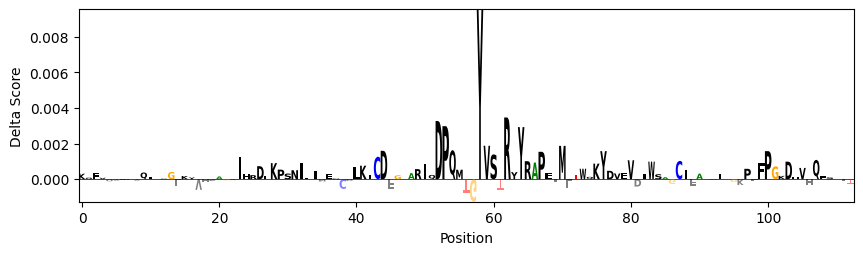

In [58]:
import matplotlib.pyplot as plt
import logomaker

delta_scores = np.array(average_scores_df['delta_lipnorm']).astype(np.float32)
sequence = sequence_trim

# Create an empty DataFrame
logo_df = pd.DataFrame({
    'letter': list(sequence),
    'delta': delta_scores
})

data = {'letter': list(sequence), 'delta': delta_scores}
logo_df = pd.DataFrame(data)

logo_df['delta'] = pd.to_numeric(logo_df['delta'], errors='coerce')

logo_df.dropna(inplace=True)

unique_symbols = set(sequence)
full_matrix = pd.DataFrame(0.0, index=np.arange(len(logo_df)), columns=unique_symbols)
for i, (letter, score) in enumerate(zip(logo_df['letter'], logo_df['delta'])):
    if letter in full_matrix.columns:
        full_matrix.at[i, letter] = score
plt.figure(figsize=(40, 6))

# Create the logo
logo = logomaker.Logo(full_matrix, color_scheme='classic', fade_below=0.5)
logo.ax.set_xlabel('Position')
logo.ax.set_ylabel('Delta Score')
plt.show()